### Import libraries


In [1]:
import os
import requests
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import pandas as pd
import time
import string
import io
from nltk import word_tokenize
import os.path
import os
import string
import nltk
from nltk.probability import FreqDist
import numpy as np
import matplotlib.pyplot as plt
import stanfordnlp
from spacy_stanfordnlp import StanfordNLPLanguage
import re

In [7]:
stanfordnlp.download("ru")

Using the default treebank "ru_syntagrus" for language "ru".
Would you like to download the models for: ru_syntagrus now? (Y/n)
y

Default download directory: /root/stanfordnlp_resources
Hit enter to continue or type an alternate directory.


Download location: /root/stanfordnlp_resources/ru_syntagrus_models.zip


100%|██████████| 236M/236M [00:40<00:00, 5.89MB/s]



Download complete.  Models saved to: /root/stanfordnlp_resources/ru_syntagrus_models.zip
Extracting models file for: ru_syntagrus
Cleaning up...Done.


In [6]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
snlp = stanfordnlp.Pipeline(lang="ru")
nlp = StanfordNLPLanguage(snlp)

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/root/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_tokenizer.pt', 'lang': 'ru', 'shorthand': 'ru_syntagrus', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/root/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_tagger.pt', 'pretrain_path': '/root/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus.pretrain.pt', 'lang': 'ru', 'shorthand': 'ru_syntagrus', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/root/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_lemmatizer.pt', 'lang': 'ru', 'shorthand': 'ru_syntagrus', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': '/root/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_parser.pt', 'pretrain_path': '/root/sta

### Data Preparation


In [7]:
from nltk.corpus import stopwords

def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])
spec_chars = string.punctuation + 'xa0«»xad' 

In [8]:
stop_words = stopwords.words('russian')

#### Parsing

Download the text dataset, later it will be split into two samples.


In [20]:

d = pd.read_csv('/content/drive/MyDrive/Clustering/patents.csv',nrows=4000)

In [22]:
d = d.drop("Unnamed: 0", axis = 1)

In [23]:
d.head()

,name,text
0,RU2725470C1.pdf,РОССИЙСКАЯ ФЕДЕРАЦИЯ\n\n(19) RU (11)\n(51) МПК...
1,RU2712619C1.pdf,РОССИЙСКАЯ ФЕДЕРАЦИЯ\n\n(19) RU (11)\n(51) МПК...
2,RU2733887C2.pdf,РОССИЙСКАЯ ФЕДЕРАЦИЯ\n\n(19) RU (11)\n(51) МПК...
3,RU2721275C2.pdf,РОССИЙСКАЯ ФЕДЕРАЦИЯ\n\nФЕДЕРАЛЬНАЯ СЛУЖБА\n\n...
4,RU2729118C2.pdf,РОССИЙСКАЯ ФЕДЕРАЦИЯ\n\n2 729 118(13) C2\n\n(1...


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Clustering/clusters.csv ', delimiter  = ",")

In [ ]:
d = d.reindex(np.random.permutation(d.index))

In [ ]:
d = d.reset_index(drop = True)

In [ ]:
df = df.drop("Unnamed: 0", axis = 1)

In [ ]:
d.text = d.text.apply(lambda x : remove_chars_from_text(x,spec_chars))
d.text = d.text.apply(lambda x : re.sub(r'\n'," ",x))

In [ ]:
d["abstract"]  = d.text.apply(lambda x : re.findall(r'54[^_]+',x.lower()))
d["abstract"]  = d["abstract"].apply(lambda x : " ".join(map(str,x)))

In [ ]:
d["abstract"] = d["abstract"].apply(lambda x : re.sub(r"[a-zA-z]","",str(x)))
d["abstract"] = d["abstract"].apply(lambda x : re.sub(r"[0-9]","",x))

In [22]:
d["tokens"] = d["abstract"].apply(lambda x: x.split())

In [ ]:
variance = {}

for i in range(2000):
  norm = []
  a = df["tokens"][i]
  for token in a:
      try:
          token1 = nlp(token)
          for j in token1:
            norm.append(j.lemma_)
      except RuntimeError:
           norm.append(token)
  fdist = FreqDist(norm)
  variance[df["name"][i]] =  fdist 

In [27]:
variance1 = pd.DataFrame(variance)
variance1.to_csv('/content/drive/MyDrive/Clustering/frequensy.csv')

In [ ]:
a = set()
for i in range(2000):
  a = i+2000
  if len(d.tokens[a]) == 0:
      d = d.drop(a,axis = 0)

In [ ]:
df = [2000:]

In [ ]:
d = d[:2000]

### Cluster Analysis 


In [4]:
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [9]:

vectorizer = TfidfVectorizer(max_df=0.2, max_features=600,
                                 min_df=0.01, stop_words = stop_words,
                                 use_idf=True, ngram_range=(1,3))
X = vectorizer.fit_transform(df["abstract"].values)

In [ ]:
X_val = vectorizer.transform(d["abstract"].values)

In [31]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
model = SentenceTransformer('distilbert-base-nli-mean-tokens')


In [32]:
corpus_embeddings = model.encode(df["abstract"].values)

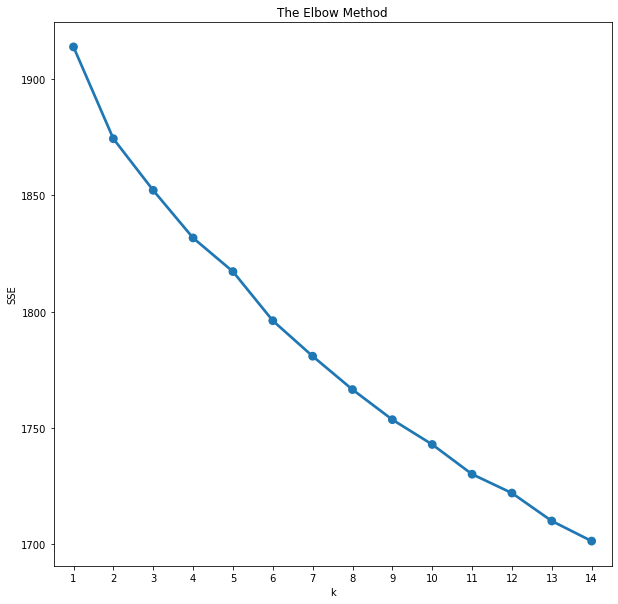

In [14]:

fig, ax = plt.subplots(figsize=(10, 10))
sse = {}
for k in range(1,15):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
num_clusters = 8
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(X)
cluster_assignment = clustering_model.labels_

In [33]:
num_clusters = 8
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [ ]:
df['cluster_8'] = clustering_model.labels_

In [ ]:
cl = clustering_model.predict(X_val)

In [ ]:
cl

array([2, 3, 2, ..., 5, 2, 2], dtype=int32)

In [ ]:
d['cluster_8'] = cl

In [ ]:
df['cluster_8'].value_counts()

2    562
0    393
3    379
1    249
7    160
6    117
5     88
4     52
Name: cluster_8, dtype: int64

In [ ]:
d['cluster_8'].value_counts()

2    749
0    380
3    322
1    207
7    139
6    102
5     62
4     39
Name: cluster_8, dtype: int64

In [ ]:
df.to_csv('/content/drive/MyDrive/Clustering/clusters.csv ')

In [ ]:
d.to_csv('/content/drive/MyDrive/Clustering/validation.csv ')

### Vizualization of results

In [34]:

centroids = clustering_model.cluster_centers_
clusters = clustering_model.labels_.tolist()

In [ ]:
terms = vectorizer.get_feature_names()

In [ ]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = clustering_model.cluster_centers_.argsort()[:, ::-1] 

for i in range(8):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, : 15]: 
        print(terms[ind], end=',')
    print() 
    print() 
    
print()
print()

Top terms per cluster:

Cluster 0 words:получения,композиции,кислоты,материала,композиция,иили,мас,основе,способу,материал,изготовления,газа,смеси,слой,качестве,

Cluster 1 words:данных,изображения,информации,изображений,блока,кодирования,декодирования,множества,основе,сигнала,первого,устройства,данные,передачи,блоков,

Cluster 2 words:элемент,часть,части,второй,устройства,поверхности,аэрозоль,первой,узел,направлении,корпуса,элемента,корпус,поверхность,отверстие,

Cluster 3 words:лечения,антитела,клеток,рака,человека,заболевания,применение,антитело,заболеваний,настоящее,последовательность,композиции,против,применения,например,

Cluster 4 words:транспортного,транспортного средства,средства,средство,система,панели,управления,средств,камеры,достигается,узел,первого,множество,стекла,данных,

Cluster 5 words:связи,беспроводной,передачи,линии связи,беспроводной связи,линии,доступа,управления,сети,ресурсов,устройства,канала,данных,информации,основе,

Cluster 6 words:алкил,независимо,формулы,а

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state= 42)
features = pca.fit_transform(X.toarray())

cluster_centers = pca.transform(centroids)

In [ ]:
from sklearn.metrics.cluster import fowlkes_mallows_score
fowlkes_mallows_score( d['cluster_8'].sort_values(), df['cluster_8'].sort_values())

0.7629166528775384

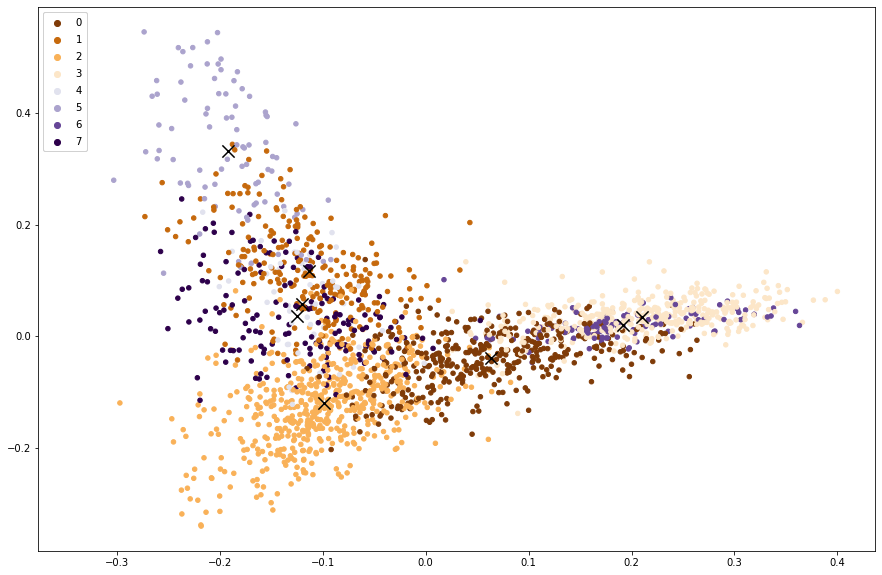

In [ ]:
fig, ax= plt.subplots(figsize=(15,10))

scatter = plt.scatter(features[:,0], features[:,1], c = clusters,cmap = "PuOr",s =20 )
legend1 = ax.legend(*scatter.legend_elements(num = 8), 
                    loc="upper left",)
plt.scatter(cluster_centers[:, 0], cluster_centers[:,1], marker='x', s=150, c='black')
ax.add_artist(legend1)
plt.show()

With Bert

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state= 42)
features = pca.fit_transform(corpus_embeddings)

cluster_centers = pca.transform(centroids)

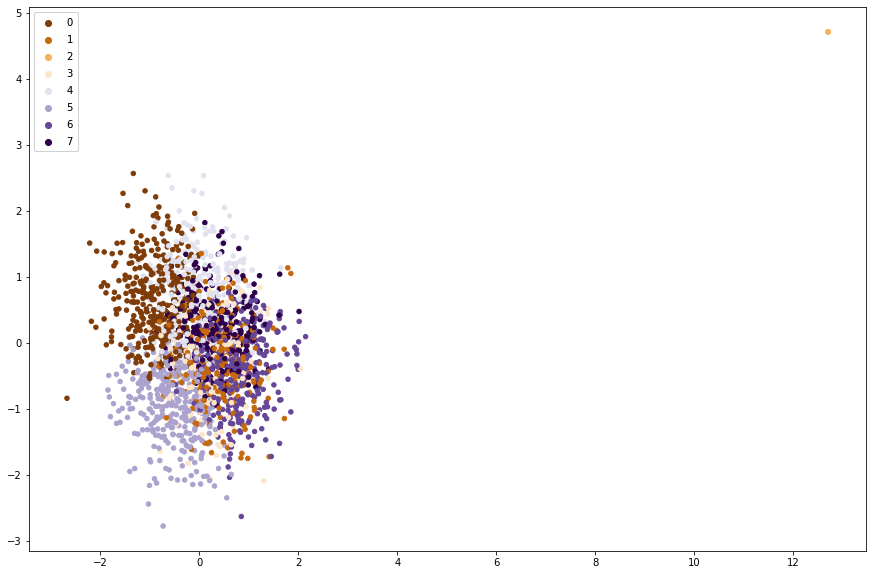

In [38]:
fig, ax= plt.subplots(figsize=(15,10))

scatter = plt.scatter(features[:,0], features[:,1], c = cluster_assignment,cmap = "PuOr",s =20 )
legend1 = ax.legend(*scatter.legend_elements(num = 8), 
                    loc="upper left",)
ax.add_artist(legend1)
plt.show()